<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting ephys recording from organoids

<strong>Input Data:</strong>

`liwang_organoid_recordings_data.xlsx` 


<strong>Figures:</strong>

`fig4`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import numpy as np

from ABCA7lof2.utils import apply_custom_plot_style
from ABCA7lof2.boxplotting import plot_boxplot_by_treatment, detect_outliers_iqr
apply_custom_plot_style()

outlier removal

In [2]:
#### Plot without outliers and zero cells removed

import pandas as pd

# Load data from the Excel file
file_path = '../../activity_data/liwang_organoid_recordings_data.xlsx'
data = pd.read_excel(file_path, header=None)

# Display the first few rows of the dataframe to ensure it loaded correctly
all_activity_no_outliers_data = data.iloc[2:]

all_activity_no_outliers_data.columns = all_activity_no_outliers_data.iloc[0] 
all_activity_no_outliers_data = all_activity_no_outliers_data[1:]
df = all_activity_no_outliers_data.iloc[:,:3] # this is "All Y622+Choline data"
df.reset_index(drop=True, inplace=True)
df = df[:33]
df_melted = df.melt(id_vars=None, var_name='Condition', value_name='Value')
df_melted = df_melted.dropna()

df_melted = df_melted[df_melted['Value'] != 0]



df_melted['Value'] = df_melted['Value'].astype(float)

dictionary = {'Y622': 'Y', 'Control (ApoE3)': 'E3', 'Y622+Choline': 'Y+C'}
df_melted['line'] = df_melted['Condition'].map(dictionary)
df_melted['line'].fillna('E3', inplace=True)
df_melted['line'].values


outliers, lb, ub = detect_outliers_iqr(df_melted['Value'].values)
df_melted_outliers_removed = df_melted[np.invert(outliers)]


/var/folders/y7/zpj5hbtd2bl78b1t9h2723hw0000gn/T/ipykernel_98182/4039120952.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_melted['line'].fillna('E3', inplace=True)


In [3]:
df_melted_outliers_removed['Condition'].value_counts()

Condition
Y622               13
Y622+Choline        9
Control (ApoE3)     7
Name: count, dtype: int64

In [4]:
df_melted[(outliers)]

,Condition,Value,line
34,Y622,9.383333,Y
86,Y622+Choline,6.150000,Y+C


Do stats

In [5]:
from scipy.stats import shapiro, levene, ttest_ind

group1 = df_melted_outliers_removed[df_melted_outliers_removed['line'] == 'E3']['Value']
group2 = df_melted_outliers_removed[df_melted_outliers_removed['line'] == 'Y']['Value']
group3 = df_melted_outliers_removed[df_melted_outliers_removed['line'] == 'Y+C']['Value']

stat1, p_norm1 = shapiro(group1)
stat2, p_norm2 = shapiro(group2)
stat3, p_norm3 = shapiro(group3)
print('comparison: E3, Y, Y+C')
print('p-values normal distribution: ', p_norm1, p_norm2, p_norm3)

stat, p_levene = levene(group1, group2)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p-value levene test E3 vs Y: ', p_levene)

stat, p_levene = levene(group2, group3)
# Decide whether to assume equal variances
equal_var = p_levene > 0.05 
print('p-value levene test Y vs Y+C: ', p_levene)



comparison: E3, Y, Y+C
p-values normal distribution:  0.012393030082758539 0.11512726781662548 0.07387723087606098
p-value levene test E3 vs Y:  0.7556145746567645
p-value levene test Y vs Y+C:  0.888334866461264


In [6]:
from scipy.stats import mannwhitneyu

# Assume group1 and group2 are your data arrays
u_stat, p_valu_A = mannwhitneyu(group1, group2, alternative='two-sided')
u_stat, p_valu_B = mannwhitneyu(group2, group3, alternative='two-sided')

formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_valu_A, p_valu_B]]
formatted_pvalues

['p=0.004', 'p=0.016']

plot the data

/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/boxplotting.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


E3 vs. Y: p=0.004
Y vs. Y+C: p=0.016


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


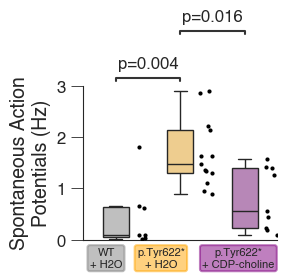

In [7]:
fig, (ax1) = plt.subplots(1, 1, figsize=(2.5, 2))

plt.sca(ax1)

ax1 = plot_boxplot_by_treatment(df_melted_outliers_removed, 'line', 'Value', order = ['E3', 'Y', 'Y+C'], pairs = [('E3', 'Y'), ('Y', 'Y+C')],palette={'E3': 'grey', 'Y': 'orange', 'Y+C': 'purple'}, 
                                ylim = np.max(df_melted_outliers_removed['Value']+0.1), pvalues=formatted_pvalues, jitter=0.1)

ax1.set_xticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('Spontaneous Action\nPotentials (Hz)')

ax1.text(-0.15, -0.05, "WT\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="grey", ec="grey", alpha=0.5), fontsize=8)
ax1.text(0.7, -0.05, "p.Tyr622*\n+ H2O", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="orange", ec="orange", alpha=0.5), fontsize=8)
ax1.text(1.9, -0.05, "p.Tyr622*\n+ CDP-choline", ha='center', va='top', transform=ax1.get_xaxis_transform(),
         bbox=dict(boxstyle="round,pad=0.2", fc="purple", ec="purple", alpha=0.5), fontsize=8)


#plt.subplots_adjust(left=0.07, right=0.9, top=0.8, bottom=0.08, wspace=0.4)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig4/cortical_organoids_ephys.pdf', dpi=300, bbox_inches='tight')

Also significant without outliers removed

In [8]:
group1 = df_melted[df_melted['line'] == 'E3']['Value']
group2 = df_melted[df_melted['line'] == 'Y']['Value']
group3 = df_melted[df_melted['line'] == 'Y+C']['Value']

# Assume group1 and group2 are your data arrays
u_stat, p_valu_A = mannwhitneyu(group1, group2, alternative='two-sided')
u_stat, p_valu_B = mannwhitneyu(group2, group3, alternative='two-sided')

formatted_pvalues = [f"p={p:.3f}" if p>0.001 else f"p={p:.3e}" for p in [p_valu_A, p_valu_B]]
formatted_pvalues

['p=0.003', 'p=0.043']